In [1]:
import os

from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

actions = []
scores = []
screens = []

action_files = os.listdir("saved_gameplay/actions/")
action_files.sort()

for action_file in action_files:
  file_name = "saved_gameplay/actions/" + action_file
  action = np.load(file_name)
  actions.append(action)

with open("saved_gameplay/scores.txt") as f:
  for l in f:
    scores.append(int(l))

screen_files = os.listdir("saved_gameplay/screens/")
screen_files.sort()

for screen_file in screen_files:
  file_name = "saved_gameplay/screens/" + screen_file
  screen = np.load(file_name)
  screens.append(screen)

action: [0 0 1]
score: 0


(200, 280, 3)

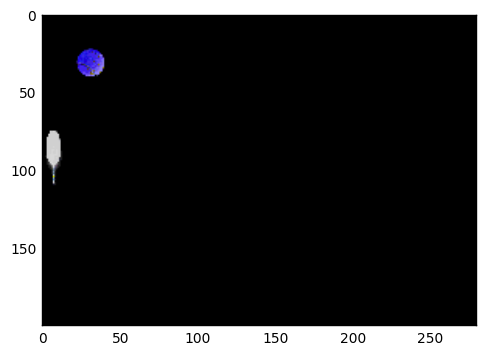

In [2]:
# red_screens = [get_channels_from_hex(s)[0] for s in screens]
plt.imshow(screens[0])
print("action:", actions[0])
print("score:", scores[0])
screens[0].shape

In [3]:
# Start with a simple MLP that takes two sequential screens and predicts the move
# based on some play history (probably a human player history)
# We're going to use 2 screens to give a sense of velocity to the neural network

# this is a really simple method that uses no reinforcement learning, and no convolutional nets

from functools import reduce
from keras.models import Sequential
from keras.layers import Dense

X = []
Y = []

for i in range(0, len(screens)-2, 2):
  screen1 = screens[i].flatten()
  screen2 = screens[i+1].flatten()
  two_screens = np.concatenate((screen1, screen2))
  X.append(two_screens)
  Y.append(actions[i + 1])

X = np.array(X)
Y = np.array(Y)

screen_pixels = reduce(lambda x, y: x*y, screens[0].shape)
input_dim = screen_pixels * 2

Using TensorFlow backend.


In [4]:
# make simple MLP model using keras
# by the way, if you have a small memory GPU this will blow it up


model = Sequential()
model.add(Dense(12, input_dim=input_dim, init='uniform', activation='relu'))
model.add(Dense(8, init='uniform', activation='relu'))
model.add(Dense(3, init='uniform', activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(X, Y, nb_epoch=5, batch_size=10)

model.save("saved_models/simple_MLP_supervised_weights.h5")

Epoch 1/5
132/132 [==============================] - 1s - loss: 0.6149 - acc: 0.7399     
Epoch 2/5
132/132 [==============================] - 1s - loss: 0.3046 - acc: 0.8864     
Epoch 3/5
132/132 [==============================] - 1s - loss: 0.2355 - acc: 0.9040     
Epoch 4/5
132/132 [==============================] - 1s - loss: 0.1869 - acc: 0.9167     
Epoch 5/5
132/132 [==============================] - 1s - loss: 0.1673 - acc: 0.9318     


In [5]:
# lets make an importable function that takes two screens and returns an
# output from the above simplistic model
# we can import this into a game play module and let the computer play
from keras.models import load_model

model = load_model("saved_models/simple_MLP_supervised_weights.h5")
def simple_computer_player(two_screens):
  action = model.predict(X[0, np.newaxis], batch_size=1, verbose=0)[0]
  return action

# here's an example of the simple_computer_player in action:
simple_computer_player(X[0])

array([ 0.00873377,  0.03249474,  0.91946584], dtype=float32)

In [11]:
input_dim=screens[0].flatten().shape[0]

168000

In [1]:
# modified from https://github.com/keon/deep-q-learning/blob/master/cartpole.py

import copy
import gym
import numpy as np
from collections import deque
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import RMSprop

episodes = 1000

class DQNAgent:
  def __init__(self, env):
    self.env = env
    self.memory = deque(maxlen=10000)
    self.gamma = 0.9  # decay rate
    self.epsilon = 0.7  # exploration
    self.epsilon_decay = .99
    self.epsilon_min = 0.05
    self.learning_rate = 0.0001
    self._build_model()

  def _build_model(self):
    # Deep-Q learning Model
    model = Sequential()
    model.add(Dense(64, input_dim=input_dim, activation='tanh', init='he_uniform'))
    model.add(Dense(128, activation='tanh', init='he_uniform'))
    model.add(Dense(128, activation='tanh', init='he_uniform'))
    model.add(Dense(2, activation='linear', init='he_uniform'))
    model.compile(loss='mse', optimizer=RMSprop(lr=self.learning_rate))
    self.model = model

  def remember(self, state, action, reward, next_state):
    self.memory.append((state, action, reward, next_state))

  def act(self, state):
    if np.random.rand() <= self.epsilon:
      return self.env.action_space.sample()
    act_values = self.model.predict(state)
    return np.argmax(act_values[0])  # returns action

  def replay(self, batch_size):
    batchs = min(batch_size, len(self.memory))
    batchs = np.random.choice(len(self.memory), batchs)
    for i in batchs:
      state, action, reward, next_state = self.memory[i]
      target = reward + self.gamma * np.amax(self.model.predict(next_state)[0])
      target_f = self.model.predict(state)
      target_f[0][action] = target
      self.model.fit(state, target_f, nb_epoch=1, verbose=0)
    if self.epsilon > self.epsilon_min:
      self.epsilon *= self.epsilon_decay


env = gym.make('CartPole-v0')
agent = DQNAgent(env)

# run an episode
for e in range(episodes):
  state = env.reset()
  state = np.reshape(state, [1, 4])
  
  # run for 5000 time steps per episode
  for time_t in range(5000):
    env.render()
    action = agent.act(state)
    next_state, reward, done, _ = env.step(action)
    next_state = np.reshape(next_state, [1, 4])
    reward = -100 if done else reward
    agent.remember(state, action, reward, next_state)
    state = copy.deepcopy(next_state)
    if done:
      print("episode: {}/{}, score: {}, memory size: {}, e: {}"
            .format(e, episodes, time_t, len(agent.memory), agent.epsilon))
      break # if done go to next episode
    agent.replay(32)

Using TensorFlow backend.
[2017-02-09 11:20:16,118] Making new env: CartPole-v0


episode: 0/1000, score: 14, memory size: 15, e: 0.6081220689382846
episode: 1/1000, score: 10, memory size: 26, e: 0.549974698565053
episode: 2/1000, score: 8, memory size: 35, e: 0.5074862351704972
episode: 3/1000, score: 10, memory size: 46, e: 0.4589614544019004
episode: 4/1000, score: 10, memory size: 57, e: 0.4150765124810495
episode: 5/1000, score: 9, memory size: 67, e: 0.3791795531767974
episode: 6/1000, score: 10, memory size: 78, e: 0.34292319110294334
episode: 7/1000, score: 10, memory size: 89, e: 0.3101335871383207
episode: 8/1000, score: 9, memory size: 99, e: 0.2833123808748265
episode: 9/1000, score: 7, memory size: 107, e: 0.2640656528464528
episode: 10/1000, score: 13, memory size: 121, e: 0.23172316182470953
episode: 11/1000, score: 75, memory size: 197, e: 0.10904582450069819
episode: 12/1000, score: 10, memory size: 208, e: 0.09861908903298736
episode: 13/1000, score: 53, memory size: 262, e: 0.05789303266353113
episode: 14/1000, score: 83, memory size: 346, e: 0.0

In [2]:
agent.memory[0]

(array([[ 0.17872001, -0.74357337, -0.12579126,  0.88507812]]),
 1,
 1.0,
 array([[ 0.16384854, -0.54698866, -0.10808969,  0.55564578]]))